# Dimensionality Reduction

Many Machine Learning problems involve thousands or even millions of features for each training instance. Not only does this make training extremely slow, it can also make it much harder to find a good solution, as we will see. This problem is often referred to as *curse of dimensionality*.

Fortunately, in real-world problems, it is often possible to reduce the number of features considerably, turning an intractable problem into a tractable one. For example, consider the MNIST images: the pixels on the image borders are almost always white, so you could completely drop these pixels from the training set without losing much information. Moreover, two neighboring pixels are often highly correlated: if you merge them into a single pixel (e.g. by taking the mean of the two pixel intensities), you will not lose much information.

**Caution**:

Reducing dimensionality does lose some information (just ike compressing an image to JPEG can degrade its quality), so even though it will speed up training, it may also make your system perform slighly worse. It also makes your pipelines a bit more complex and thus harder to maintain. So you should first try to train your system with the original data before considering using dimensionaliy reduction if training is too slow. In some cases, however, reducing the dimensionality of the training data may filter out some noise and unnecessary details and thus result in higher preformance (but in general it won't; it will just speed up training).

Apart from speeding up training, dimensionality reduction is also extremely useful for data visualization (DataViz). Reducing the number of dimensions down to two (or three) makes it possible to plot a condensed view of a high-dimensional training set on a graph and often fain some important insights by visually detecting patterns, such as clusters. Moreover, DataViz is essential to communicate your conclusions to people who are not data scientists, in particular decision makers who will use your results.

In this chapter we will discuss the curse of dimensionality and get a sense of what goes on in high-dimensional space. Then, we will present the two main approaches to dimensionality reduction (projection and Manifold Learning), and we will go through three of the most popular dimensionality reduction techniques: PCA, Kernel PCA, and LLE.

## The Curse of Dimensionality

We are so used to living in three dimensions that our intuition fails us when we try to imagine a high-dimensional space. Even a basic 4D hypercube is incredibly hard to picture in our mind, let alone a 200-dimensional ellipsoid bent in a 1000-dimensional space.

It turns out that many things behave very differently in high-dimensional space. For example, if you pick a random point in a unit square (a 1x1 square), it will have only about a 0.4% chance of being located less than 0.001 from a border (in other words, it is very unlikely that a random point will be "extreme" along any dimension). But in a 10,000 dimensional unit hypercube (a 1x1x...x1 cube, with ten thousands 1s), this probability is greater than 99.99999%. Most points in a high-dimensional hypercube are very close to the border.

Here is a more troublesome difference: if you pick two points randomly in a unit square, the distance between these two points will be, on average, roughly 0.52. If you pick two random points in a unit 3D cube, the average distance will be roughly 0.66. But what about two points picked randomly in a 1M-dimensional hypercube? Well, the average distance, believe it or not, will be about 408.25! This is quite counterintuitive: how can two points be so far apat when they both lie within the same hypercube? This fact implies that high-dimensional datasets are at risk of being very sparse: most trainining instances are likely to be far away from each other. Of course, this also means that a new instance will likely be far away from any training instance, making predictions much less reliable than in lower dimensions, since they will be based on much larger extrapolations. 

In short, the more dimensions the training set has, the greater the risk of overfitting it.

In theory, one solution to the curse of dimensionality could be to increase the size of the training set to reach a sufficient density of training instances. Unfortunately, in practice, the number of training instances required to reach a given density grows exponentially with the number of dimensions. With just 100 features (much less than in the MNIST problem -~780), you would need more training instances than atoms in the observable universe in order for training instances to be within 0.1 of each other on average, assuming they were spread out uniformly across all dimensions.

## Main Approaches for Dimensionality Reduction

Before we dive into specific dimensionality reduction algorithms, let's take a look at the two main approaches to reducing dimensionality: projection and Manifold Learning.

### Projection

In most real-world problems, training instances are *not* spread out uniformly across all dimensions. Many features are almost constant, while others are highly correlated (as discussed earlier for MNIST). As a result, all training instances actually lie within (or close to) a much lower-dimensional *subspace* of the high-dimensional space (image below). 


![alt text](highD.PNG "High Dimensional")

Notice that all training instances lie close to a plane: this is a lower-dimensional (2D) subspace of the high-dimensional (3D) space. Now if we project every training instance perpendicularly onto this subspace (as represented by the short lines connecting the instances to the plane), we get the new 2D dataset shown in the image below. We have just reduced the dataset's dimensionality from 3D to 2D. Note that the axes correspond to new features $z_1$ and $z_2$ (the coordinates of the projections on the plane).

![alt text](lessD.PNG "Less high Dimensional")

However, projection is not always the best approach to dimensionality reduction. In many cases the subspace may twist and turn, such as in the infamour *Swiss roll* toy dataset in the figure below:

![alt text](swiss3d.PNG "Swiss 3d")

Simply projecting onto a plane (e.g. by dropping $x_3$) would squash different layers of the Swiss roll together, as shown on the left of the figure below. However, what you really want is to unroll the Swiss roll to obtain the 2D dataset on the right

![alt text](swiss2d.PNG "Swiss 2d")

### Manifold Learning

The Swiss roll is an example of a 2D *manifold*. Put simply, a 2D manifold is a 2D shape that can be bent and twisted in a higher-dimensional space. More generally, a d-dimensional manifold is a part of an n-dimensional space (where d < n) that locally resembles a d-dimensional hyperplane. In the case of the Swiss roll, d = 2 and n = 3: it locally resembles a 2D plane, but it is rolled in the third dimension.

Many dimensionality reduction algorithms work by modeling the *manifold* on which the training instances lie; this is called *Manifold Learning*. It relies on the *manifold assumption*, also called the *manifold hypothesis*, which holds that most real-world high-dimensional datasets lie close to a much lower-dimensional manifold. This assumption is very often empirically observed.

Once again, think about the MNIST dataset: all handwritten digit images have some similarities. They are made of connected lines, the borders are white, they are more or less centered, and so on. If you randomly generated images, only a ridiculously tiny fraction of them would look like handwritten digits. In other words, the degrees of freedom available to you if you try to create a digit image are dramatically lower than the degrees of freedom you would have if you were allowed to generate any image you wanted. These constraints tend to squeeze the dataset into a lower-dimensional manifold.

The manifold assumption is often accompanied by another implicit assumption: that the task at hand (e.g. classification or regression) will be simpler if expressed in the lower-dimensional space of the manifold. However, this assumption does not always hold.

In short, if you reduce the dimensionality of your training set before training a model, it will usually speed up training, but it may not always lead to a better or simpler solution; it all depends on the dataset.

## PCA

*Principal Component Analysis* (PCA) is by far the most popular dimensionality reduction algorithm. First it identifies the hyperplane that lies closest to the data, and then it **projects** the data onto it.

### Preserving the Variance

Before you can project the training set onto a lower-dimensional hyperplane, you first need to choose the right hyperplane. For example, a simple 2D dataset is represented in the left of the figure below, along with three different axes (i.e. one-dimensioanl hyperplanes). On the right is the result of the projection of the dataset onto each of these axes. As you can see, the projection onto the solid line preserves the maximum variance.

![alt text](PCA.PNG "PCA")

It seems reasonable to select the axis that preserves the maximum amount of variance, as it will most likely lose less information than the other projections. Another way to justify this choice is that it is the axis that minimizes the mean squared distance between the original dataset and its projection onto that axis (closest to the data).

### Principal Components

PCA identifies the axis that accounts for the largest amount of variance in the training set. It also finds a second axis, orthogonal to the first one, that accounts for the largest amount of the remaining variance. In the 2D example above there is no choice: it is the dotted line. If it were a higher-dimensional dataset, PCA would also find a third axis, orthogonal to both previous axes, and a fourth, a fifth, and so on -- as many axes as the number of dimensions in the dataset.

The unit vector that defines the $i^{th}$ axis is called the $i^{th}$ *principal component*
 (PC). In the figure above, the $1^{st}$ PC is $c_1$ and the $2^{nd}$ PC is $c_2$.
 
 **Note**:
 
 The direction of the principal components is not stable: if you perturb the training set slighly and run PCA again, some of the new PCs may point in the opposite direction of the original PCs. However, they will generally still lie on the same axes. In some cases, a pair of PCs may even rotate or swap, but the plane they define will generally remain the same.
 
 So how can you find the principal components of a training set? Luckily, there is a standard matrix factorization technique called *Singular Value Decomposition* (SVD) that can decompose the training set matrix $X$ into the matrix multiplication of three matrices $U \Sigma V^T$, where V contains all the principal components that we are looking for.
 
 The following Python code uses NumPy's svd() function to obtain all the principal components of the training set, then extracts the first two PCs:

In [1]:
import numpy as np
# simulate 4D dataset
X1 = np.random.normal(0, 1, 100)
X2 = np.random.normal(5, 10, 100)
X3 = np.random.normal(20, 5, 100)
X4 = np.random.normal(3, 2, 100)
X = np.c_[X1, X2, X3, X4]
# first two PCs
X_centered = X - X.mean(axis = 0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

**Caution**:

PCA assumes that the dataset is centered around the origin. As we will see, Scikit-Learn's PCA classes take care of centering the data for you. However, if you implement PCA yourself (as in the preceding example), or if you use other libraries, don't forget to center the data first.

### Projecting Down to d Dimensions

Once you have identified all the principal components, you can reduce the dimensionality of the dataset down to d dimensions by projecting it onto the hyperplane defined by the first d principal components. Selecting this hyperplane ensures that the projection will preserve as much variance as possible.

To project the training set onto the hyperplane, you can simply compute the matrix multiplication of the training set matrix $X$ by the matrix $W_d$ defined as the matrix contanining the first d principal components (i.e. the matrix composed of the first d columns of V):

$$ X_{d-proj} = XW_d$$

The following Python code projects the training set onto the plane defined by the first two principal components:

In [2]:
W2 = Vt.T[:, :2] # take the first two columns of V (the transpose of the transpose of V)
X2D = X_centered.dot(W2)

You now know how to reduce the dimensionality of any dataset down to any number of dimensions, while preserving as much variance as possible.

### Using Scikit-Learn

Scikit-Learn's PCA class implements PCA using SVD decomposition just like we did befre. The following code applies PCA to reduce the dimensionality of the dataset down to two dimensions (note that it automatically takes care of centering the data):

In [3]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

After fitting the PCA transformer to the dataset, you can access the principal components using the components_ variable (note that it contains the PCs as horizontal vectors, so, for example, the first principal component is equal to pca.components_.T[:,0]).

### Explained Variance Ratio

Another very useful piece of information is the *explained variance ratio* of each principal component, available via the explained_variance_ratio_ variable. It indicates the proportion of the dataset's variance that lies along the axis of each principal component. 

### Choosing the Right Number of Dimensions

Instead of arbitrarily choosing the number of dimensions to reduce down to, it is generally preferable to choose the number of dimensions that add up to a sufficiently large portion of the variance (e.g. 95%). Unless, of course, you are reducing dimensionality for data visualization -- in that case you will generally want to reduce the dimensionality down to 2 or 3.

The following code computes PCA without reducing dimensionality, then computes the minimum number of dimensions required to preserve 95% of the training set's variance:

In [4]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

In [5]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [6]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
print(d)

153


You could then set n_components = d and run PCA agan. However, there is a much better option: instead of specifying the number of principal components you want to preserve, you can set n_components to be a float between 0 and 1.0, indicating the ratio of variance you wish to preserve:

In [7]:
pca = PCA(n_components = 0.95) 
X_reduced = pca.fit_transform(X_train)

Yet another option is to plot the explained variance as a function of the number of dimensions (simply plot cumsum). There will usually be an elbow in the curve, where the explained variance stops growing fast. You can think of this as the intrinsic dimensionality of the dataset. In this case, you can see that reducing the dimensionality down to about 100 dimensions wouldn't lose too much explained variance

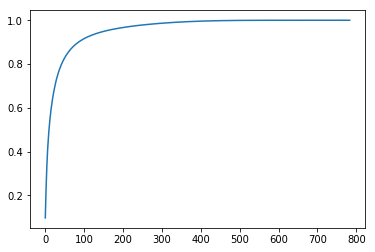

In [16]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(len(cumsum))], cumsum)
plt.show()

### PCA for Compression

Obviously after dimensionality reduction, the training set takes up much less space. For example, try applying PCA to the MNIST dataset while preserving 95% of its variance. You should find that each instance will have just over 150 features, instead of the original 784 features. So while most of the variance is preserved, the dataset is now less than 20% of its original size! This is a reasonable compression ratio, and you can see how this can speed up a classification algorithm (such an SVM classifier) tremendously.

It is also possible to decompress the reduced dataset back to 784 dimensions by applying the inverse transformation of the PCA projection. Of course this won't give you back the original data, since the projectio lost a bit of information (within the 5% variance that was dropped), but it will likely quite close to the original data. The mean squared distance between the original data and the reconstructed data (compressed and decompressed) is called the *reconstruction error*. For example, the following code compresses the MNIST dataset down to 154 dimensions, then uses the inverse_transform() method to decompress it back to 784 dimensions. 

In [9]:
pca = PCA(n_components = 154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

The equation of the inverse transformation is:

$$ X_{recovered} = X_{d-proj}W_d^T$$

### Randomized PCA

If you set the svd_solver hyperparameter to "randomized", Scikit-Learn uses a stochastic algorithm called *Randomized* PCA that quickly finds an approximation of the first d principal components. Its computational complexity is $O(m \times d^2) +O(d^3)$, instead of $O(m \times n^2) +O(n^3)$ for the full SVD approach, so it is dramatically faster than full SVD when d is much smaller than n:

In [10]:
rnd_pca = PCA(n_components = 154, svd_solver = "randomized")
X_reduced = rnd_pca.fit_transform(X_train)

by default, svd_solver is actually set to "auto": Scikit-Learn automatically uses the randomized PCA algorithm if m or n is greater than 500 and d is less than 80% of m or n, or else it uses the full SVD approach. If you want to force Scikit-Learn to use full SVD, you can set the svd_solver hyperparameter to "full".

### Incremental PCA

One problem with the preceding implementation of PCA is hat they require the whole training set to fit in memory in order for the algorithm to run. Fortunately, *Incremental* PCA (IPCA) algorithms have been developed: you can split the training set into mini-batches and feed an IPCA algorithm one mini-batch at a time. This is useful for large training sets, and also to apply PCA online (i.e. on the fly, as new instances arrive).

The following code splits the MNIST dataset into 100-mini-batches (using numpy's array_split() function) and feeds them to Scikit-Learn's IncrementalPCA class to reduce the dimensionality of the MNIST dataset down to 154 dimensions (just like before). Note that you must call the partial_fit() method with each mini-batch rather than the fit() method with the whole dataset:

In [11]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components = 154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)
    
X_reduced = inc_pca.transform(X_train)

Alternatively, you can use numpy's memmap class, which allows you to manipulate a large array stored in a binary file on disk as if it were entirely in memory; the class loads only the data it needs in memory, when it needs it. Since the IncrementalPCA class uses only a small part of the array at any given time, the memory usage remains under control. This makes it possible to call the usual fit() method, as you can see in the following code:

In [12]:
if False:
    X_mm = np.memmap(filename, dtype = "float32", mode = "readonly", shape = (mn, n))
    
    batch_size = m // n_batches
    inc_pca = IncrementalPCA(n_components = 154, batch_size = batch_size)
    inc_pca.fit(X_mm)

### Kernel PCA

In chapter 5 we discussed the kernel trick, a mathematical technique that implicitly maps instances into a very high-dimensional space (called the *feature space*), enabling nonlinear classification and regression with Support Vector Machines. Recall that a linear decision boundary in the high-dimensional space corresponds to a complex nonlinear decision boundary in the *original space*.

It turns out that the same trick can be applied to PCA, making it possible to perform complex nonlinear projections for dimensionality reduction. This is called *Kernel* PCA (kPCA). It is often good at preserving clusters of instances after projection, or sometimes even unrolling datasets that lie close to a twisted manifold.

### Selecting a Kernel and Tuning Hyperparameters

As kPCA is an unsupervised learning algorithm, there is no obvious performance measure to help you select the best kernel and hyperparameter values. However, dimensionality reduction is often a preparation step for a supervised learning task (e.g. classification), so you can simply use grid search to select the kernel and hyperparameters that lead to the best performance on that task. 

For example, the following code creates a two-step pipeline, first reducing dimensionality to two dimensions using kPCA, then applying Logistic Regression for classification. Then it uses GridSearchCV to find the best kernel and gamma value for kPCA in order to get the best classification accuracy at the end of the pipeline:

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import KernelPCA

clf = Pipeline([
    ("kpca", KernelPCA(n_components = 2)),
    ("log_reg", LogisticRegression())
])

param_grid = [{
    "kpca_gamma" : np.linspace(0.03, 0.05, 10),
    "kpca_kernel" : ["rbf", "sigmoid"]
}]

grid_search = GridSearchCV(clf, param_grid, cv = 3)
# grid_search.fit(X,y)

The best kernel and hyperparameters are then available through the best_params_ variable.

Another approach, this time entirely unsupervised, is to select the kernel and hyperparameters that yield the lowest reconstruction error. However, reconstruction is not as easy as with linear PCA. 

The figure below shows the original Swiss roll 3D dataset (top left), and the resulting 2D dataset after kPCA is applied using an RBF kernel (top right). Thanks to the kernel trick, this is mathematically equivalent to mapping the training set to an infinite-dimensional (because RBF kernel)  feature space (bottom right) using the *feature map* $\phi$, then projecting the transformed training set down to 2D using linear PCA. Notice that if we could invert the linear PCA step for a given instance in the reduced space, the reconstructed point would lie in feature space, not in the original space (e.g. like the one represented by an x in the diagram). Since the feature space is infinite-dimensional, we cannot compute the reconstruted point, and therefore we cannot compute the true reconstruction error. 

Fortunately, it is possible to find a point in the original space that would map close to the reconstructed point. This is called the reconstruction *pre-image*. Once you have this pre-image, you can measure its squared distance to the original instance. You can then select the kernel and hyperparameters that minimize this reconstruction pre-image error.

![alt text](kernelPCA.PNG "Less high Dimensional")

You may be wondering how to perform this reconstruction. One solution is to train a supervised regression model, with the projected instances as the training set and the original instances as the targets. Scikit-Learn will do this automatically if you set fit_inverse_transform = True, as shown in the following code:

In [14]:
rbf_pca = KernelPCA(n_components = 2, kernel = "rbf", gamma = 0.0433, fit_inverse_transform = True)
# X_reduced = rbf_pca.fit_transform(X)
# X_preimage = rbf_pca.inverse_transform(X_reduced)

**Note**:

By default, fit_inverse_transform = False and KernelPCA has no inverse_transform() method. This method only gets created when you set fit_inverse_transform = True.

You can then compute the reconstruction pre-image error:

In [15]:
from sklearn.metrics import mean_squared_error
#mean_squared_error(X, X_preimage)

## LLE

*Locally Linear Embedding* (LLE) is another very powerful *nonlinear dimensionality reduction* (NLDR) technique. It is a Manifold Learning technique that does not rely on projections like the previous algorithms. In a nutshell, LLE works by first measuring how each training instance linearly relates to its closest neighbors, and then looking for a low-dimensional repreentation of the trainining set where these local relationships are best preserved. This makes it particularly good at unrolling twisted manifolds, especially when there is not too much noise.

For example, the following code uses Scikit-Learn's LocallyLinearEmbedding class to unroll the Swiss roll. The resulting 2D Dataset is shown in the figure below. As you can see, the Swiss roll is completely unrolled and the distances between instances are locally well preserved. However, distances are not preserved on a larger scale: the left part of the unrolled Swiss roll is stretched, while the right part is squeezed. Nevertheless, LLE did a pretty good job at modeling the manifold.

In [53]:
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import LocallyLinearEmbedding

SR = make_swiss_roll(n_samples = 500)
X, y = SR[0], SR[1]

lle = LocallyLinearEmbedding(n_components = 2, n_neighbors = 10) 
X_reduced = lle.fit_transform(X)

Here's how LLE works: first, for each training instance $x^{(i)}$, the algorithm identifies its k closest neighbors (in the preceding code k = 10), then tries to reconstruct $x^{(i)}$ as a linear function of these neighbors. More specifically, it finds the weights $w_{i,j}$ such that the squared distance between $x^{(i)}$ and $\sum_{j = 1}^m w_{i,j}x^{(j)}$ is as small as possible, assuming $w_{i,j} = 0$ if $x^{(j)}$ is not one of the k closest neighbors of $x^{(i)}$.

Thus the first step of LLE is the constrained optimization problem described in the equation below where $W$ is the weight matrix containing all the weights $w_{i,j}$. The second constraint simply normalizes the weights for each training instance $x^{(i)}$.

$$ \hat{W} = \underset{W}{\operatorname{argmin}} \sum_{i = 1}^m (x^{(i)} - \sum_{j = 1}^m w_{i,j} X^{(j)})^2$$

$$ subject \ to \  \begin{cases}
w_{i,j} = 0  \quad \text{if} \ x^{(j)} \ \text{is not one of the k c.n. of } \ x^{(i)}\\ 
\\
\sum_{j = 1}^m w_{i,j} = 1 \quad \text{for i = 1,2, ..., m} 
\end{cases}$$

After this step, the weight matrix $\hat{W}$ encodes the local linear relationships between the training instances. Now the second step is to map the training instances into a d-dimensional space (where d < n) while preserving these local relationships as much as possible. if $z^{(i)}$ is the image of $x^{(i)}$ in this d-dimensional space, then we want the squared distance between $z^{(i)}$ and $\sum_{j = 1}^m w_{i,j} z^{(j)}$ to be as small as possible. This idea leads to the unconstrained described in the below equation. It looks very similar to the first step, but instead of keeping the instances fixed and finding the optimal weights, we are doing the reverse: keeping the weights fixed and finding the optimal position of the instances' images in the low-dimensional space. Note that Z is the matrix containing all $z^{(i)}$

$$ \hat{Z} = \underset{Z}{\operatorname{argmin}} \sum_{i = 1}^m (z^{(i)} - \sum_{j = 1}^m w_{i,j}z^{(j)})^2$$

Scikit-Learn's LLE implementation has the following computational complexity: $O(m \ log(m)n \ log(k))$ for finding the k nearest neighbors, $O(mnk^3)$ for optimizing the weights and $O(dm^2)$ for constructing the low dimensional representations. Unfortunately, the $m^2$ in the last term makes this algorithm scale poorly to very large datasets.

## Other Dimensionality Reduction Techniques

There are many other dimensionality reduction techniques, several of which are available in Scikit-Learn. Here are some of the most popular:

- *Multidimensional Scaling* (MDS) reduces dimensionality while trying to preserve the distances between the instances


- *Isomap* creates a graph by connecting each instance to its nearest neighbors, then reduces dimensionality while trying to preserve the *geodesic distances* between the instances.


- *t-Distributed Stochastic Neighbor Embedding* (t-SNE) reduces dimensionality while trying to keep similar instances close and dissimilar instances apart. It is mostly used for visualization, in particular to visualize clusters of instances in high-dimensional space (e.g., to visualize the MNIST images in 2D).


- *Linear Discriminant Analysis* (LDA) is actually a classification algorithm, but during training it learns the most discriminative axes between the classes, and these axes can then be used to define a hyperplane onto which to project the data. The benefit is that the projection will keep classes as far apart as possible, so LDA is a good technique to reduce dimensionality before running another classification algorithm such as an SVM classifier.